This notebook can be run on mybinder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fchatelaf%2Fconference-ia/HEAD?urlpath=lab/tree/notebooks5_support_vector_machine/)

# One-class SVM with non-linear kernel (RBF) for novelty detection.

One-class SVM is an *unsupervised* algorithm that learns a decision function for novelty detection: classifying new data as similar or different to the training set.

## Novelty Detection
*Quoting scikit-learn user guide*

Consider a data set of $n$ observations from the same distribution described by $p$ features. Consider now that we add one more observation to that data set. Is the new observation so different from the others that we can doubt it is regular? (i.e. does it come from the same distribution?) Or on the contrary, is it so similar to the other that we cannot distinguish it from the original observations? This is the question addressed by the novelty detection tools and methods.

In general, it is about to learn a rough, close frontier delimiting the contour of the initial observations distribution, plotted in embedding $p$-dimensional space. Then, if further observations lay within the frontier-delimited subspace, they are considered as coming from the same population than the initial observations. Otherwise, if they lay outside the frontier, we can say that they are abnormal with a given confidence in our assessment.

The One-Class SVM has been introduced in 
> [Estimating the support of a high-dimensional distribution](https://dl.acm.org/citation.cfm?id=1119749), Schölkopf, Bernhard, *et al*. Neural computation 13.7 (2001): 1443-1471,

for that purpose and implemented in the Support Vector Machines module in the `svm.OneClassSVM` object. It requires the choice of a kernel and a scalar parameter to define a frontier. The RBF kernel is usually chosen although there exists no exact formula or algorithm to set its bandwidth parameter. This is the default in the scikit-learn implementation. The $\nu$ parameter, also known as the margin of the One-Class SVM, corresponds to the probability of finding a new, but regular, observation outside the frontier.

## One-class SVM: Mathematical Formulation

SVM based one-class classification relies on identifying the smallest *hypersphere* (with radius r, and center c) consisting of all the data points. Formally, the problem can be defined in the following constrained optimization form,

$$\min_{r,c} r^2 \text{ subject to, } ||\Phi(x_i) - c||^2 \le r^2 \;\; \forall i = 1, 2, \ldots, n$$
where $\Phi(\cdot)$ is a feature expansion function.

However, the above formulation is highly restrictive, and is sensitive to the presence of outliers. Therefore, a flexible formulation, that allow for the presence of outliers is formulated as shown below,

$$\min_{r,c,\zeta} r^2 + \frac{1}{\nu n}\sum_{i=1}^{n}\zeta_i$$
$$\text{subject to, } ||\Phi(x_i) - c||^2 \le r^2 + \zeta_i \;\; \forall i = 1, 2, \ldots, n$$

From Karush-Kuhn-Tucker (KKT) optimality conditions, we get

$$c = \sum_{i=1}^{n}\alpha_i\Phi(x_i),$$

where the Lagrange multiplier $\alpha_i$'s are the solution to the following optimization problem:

$$\max_\alpha \sum_{i=1}^{n}\alpha_i k(x_i, x_i) - \sum_{i, j = 1}^{n}\alpha_i\alpha_j k(x_i, x_j)$$

subject to, $\sum_{i=1}^{n}\alpha_i = 1 \text{ and } 0 \le \alpha_i \le \frac{1}{\nu n} \text{for all } i = 1,2,...,n$, where 
$k(\cdot,\cdot)$  is the kernel function from which $\Phi()$ can be derived.

The introduction of kernel function $k(\cdot,\cdot)$ provide additional flexibility to the one-class support vector machine algorithm w.r.t. a rigid spherical frontier in the original data space.

## Toy Example

#### Generate the data sets: 
- training set with *regular* observations
- test set with both *regular* and *abnormal* observations

In [1]:
import numpy as np

np.random.RandomState(1)
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))

# Generate bimodal train data
n_train = 200 
X = 0.3 * np.random.randn(n_train//2, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
n_test = 100
X = 0.3 * np.random.randn(n_test//2, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(n_test//2, 2))

Fit the one-class model for given specified proportion of outlier

In [2]:
import sklearn.svm as svm

# Set the proba of finding a new, but regular, observation outside the frontier
nu = 0.1
# fit the model
clf = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=.1)
clf.fit(X_train)

# Compute prediction errors for novelty detection
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

Display the train + test datasets and the learned frontier to detect *novelties*

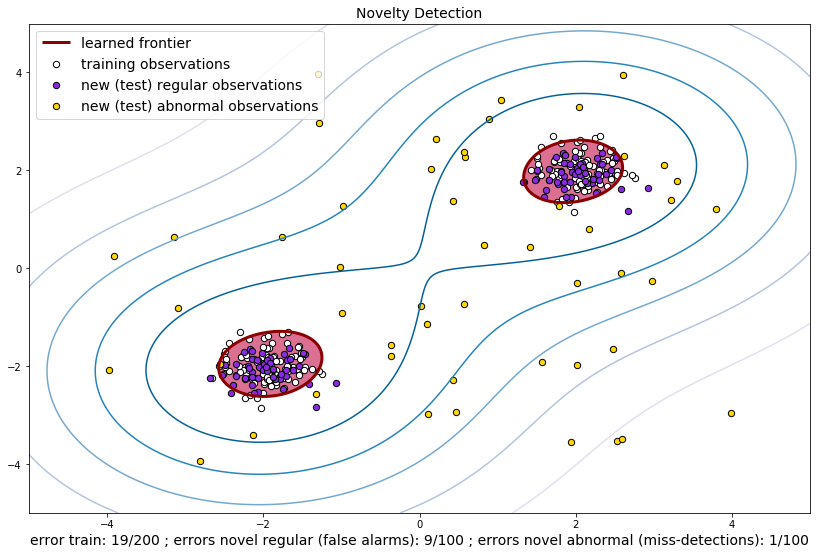

In [3]:
import matplotlib.pyplot as plt


plt.figure(figsize=(14,9))

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection", fontsize=14)
plt.contour(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=3, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new (test) regular observations", "new (test) abnormal observations"],
           loc="upper left",
           fontsize=14)
plt.xlabel(
    "error train: {}/{} ; errors novel regular (false alarms): {}/{} ; "
    "errors novel abnormal (miss-detections): {}/{}".format
    (n_error_train, n_train, n_error_test, n_test, 
     n_error_outliers, n_test), 
    fontsize=14)
plt.show()

#### Questions:
- Is this a supervised algorithm (explain why)?
- Gradually increase or decreases the probability $\nu$ in the range $(0,1)$. How does this influence the detection performances for both new *regular* and *abnormal* (novelty) samples?
- Are the results very sensitive to the choice of the gamma parameter of the RBF kernel (test different values), and justify? Is it possible to cross-validate these hyperparameters?